# DATASET LOADING

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("roshanmaur/imbalanced-tuberculosis-and-pnuemonia-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imbalanced-tuberculosis-and-pnuemonia-dataset


# IMPORTING REQUIRED LIBRARIES

In [ ]:
#importing the required libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Dense,Flatten,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.applications import  InceptionV3
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array





#PARAMETERS GENERATION

In [ ]:
image_size =299
batch_size = 32
learning_rate=1e-5

#DATA-PREPROCESSING


In [4]:
import os
import shutil

# Copy dataset into writable directory
src = "/kaggle/input/imbalanced-tuberculosis-and-pnuemonia-dataset/all_images"
dst = "/kaggle/working/all_images"

if not os.path.exists(dst):
    shutil.copytree(src, dst)
    print("Dataset copied to working directory.")


folder_path = os.path.join(dst, "universal_test")

# Delete universal_test if it exists
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Removed: {folder_path}")
else:
    print(f"Folder not found: {folder_path}")

Dataset copied to working directory.
Removed: /kaggle/working/all_images/universal_test


# TRAIN-VAL-TEST-SPLIT

In [5]:
#image Augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15

)


train_gen = data_gen.flow_from_directory(
    "/kaggle/working/all_images",
    class_mode="categorical",
    target_size=(image_size, image_size),
    batch_size=batch_size,
    subset="training"
)

val_gen = data_gen.flow_from_directory(
    "/kaggle/working/all_images",
    class_mode="categorical",
    target_size=(image_size, image_size),
    batch_size=batch_size,
    subset="validation"
)


test_image = ImageDataGenerator(rescale=1./255)

test_gen = test_image.flow_from_directory(
    "/kaggle/input/imbalanced-tuberculosis-and-pnuemonia-dataset/all_images/universal_test",
    class_mode="categorical",
    target_size=(image_size, image_size),
    batch_size=batch_size
)


Found 12854 images belonging to 3 classes.
Found 2267 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


# sample image visualisation

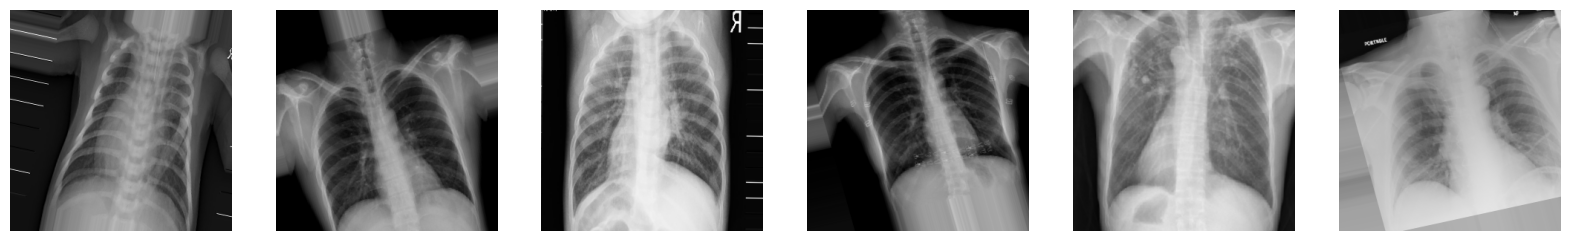

In [19]:
fig = plt.figure(figsize=(20, 5))

images, labels = next(train_gen)
for i in range(6):
    ax = fig.add_subplot(1, 6, i+1)
    ax.imshow(images[i])
    ax.axis("off")

plt.show()


# MODEL GENERATION

Transfer learning


In [6]:
base_model = InceptionV3(include_top = False, weights= "imagenet",input_shape=(image_size,image_size,3))
base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [7]:
# Regularization factor
weight_decay = 1e-4

#Genreting fully connected layers

In [8]:
x = base_model.output


# Fully connected layers

x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation="relu", kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(512, activation="relu", kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(156, activation="relu", kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(128, activation="relu", kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation="relu", kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(32, activation="relu", kernel_regularizer=l2(weight_decay))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)


x = Dense(test_gen.num_classes, activation="softmax", kernel_regularizer=l2(weight_decay))(x)

In [9]:
# Final model
model = Model(inputs=base_model.input, outputs=x)


In [10]:
# Unfreezing top layers of base_model
for layer in base_model.layers[-50:]:
    layer.trainable = True

model compilation and trainning

In [11]:
model.compile(loss= "categorical_crossentropy",optimizer=Adam(learning_rate),metrics =["accuracy"])
model.fit(train_gen,
          epochs=10,
          validation_data=val_gen)

Epoch 1/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 591s 1s/step - accuracy: 0.3560 - loss: 1.7477 - val_accuracy: 0.4186 - val_loss: 1.2977
Epoch 2/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 518s 1s/step - accuracy: 0.5091 - loss: 1.3391 - val_accuracy: 0.5152 - val_loss: 1.2424
Epoch 3/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 499s 1s/step - accuracy: 0.5929 - loss: 1.1607 - val_accuracy: 0.5201 - val_loss: 1.2380
Epoch 4/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 486s 1s/step - accuracy: 0.6345 - loss: 1.0695 - val_accuracy: 0.5549 - val_loss: 1.1906
Epoch 5/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - accuracy: 0.6767 - loss: 0.9811 - val_accuracy: 0.5964 - val_loss: 1.1605
Epoch 6/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 483s 1s/step - accuracy: 0.7121 - loss: 0.9205 - val_accuracy: 0.6114 - val_loss: 1.1712
Epoch 7/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 484s 1s/step - accuracy: 0.7407 - loss: 0.8760 - val_accuracy: 0.6621 - val_loss: 1.0909
Epoch 8/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 478s 1s/step - accuracy: 0.7638 - loss: 0.8279 - val_accu

# MODEL EVALUATION

In [12]:
score = model.evaluate(test_gen)
print(f"the loss:{score[0]},the accuracy:{score[1]}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8052 - loss: 0.7292
the loss:0.7536985278129578,the accuracy:0.7900000214576721


#VISUALISATION

model prediction

In [14]:
idx_to_class = {v: k for k, v in test_gen.class_indices.items()}

test_gen.reset()
images, labels = next(test_gen)
pred_batch = model.predict(images, verbose=0)

true_idx  = np.argmax(labels, axis=1)
pred_idx  = np.argmax(pred_batch, axis=1)

ploting 20 actual images and its prediction as tittle

<Figure size 3000x3000 with 0 Axes>

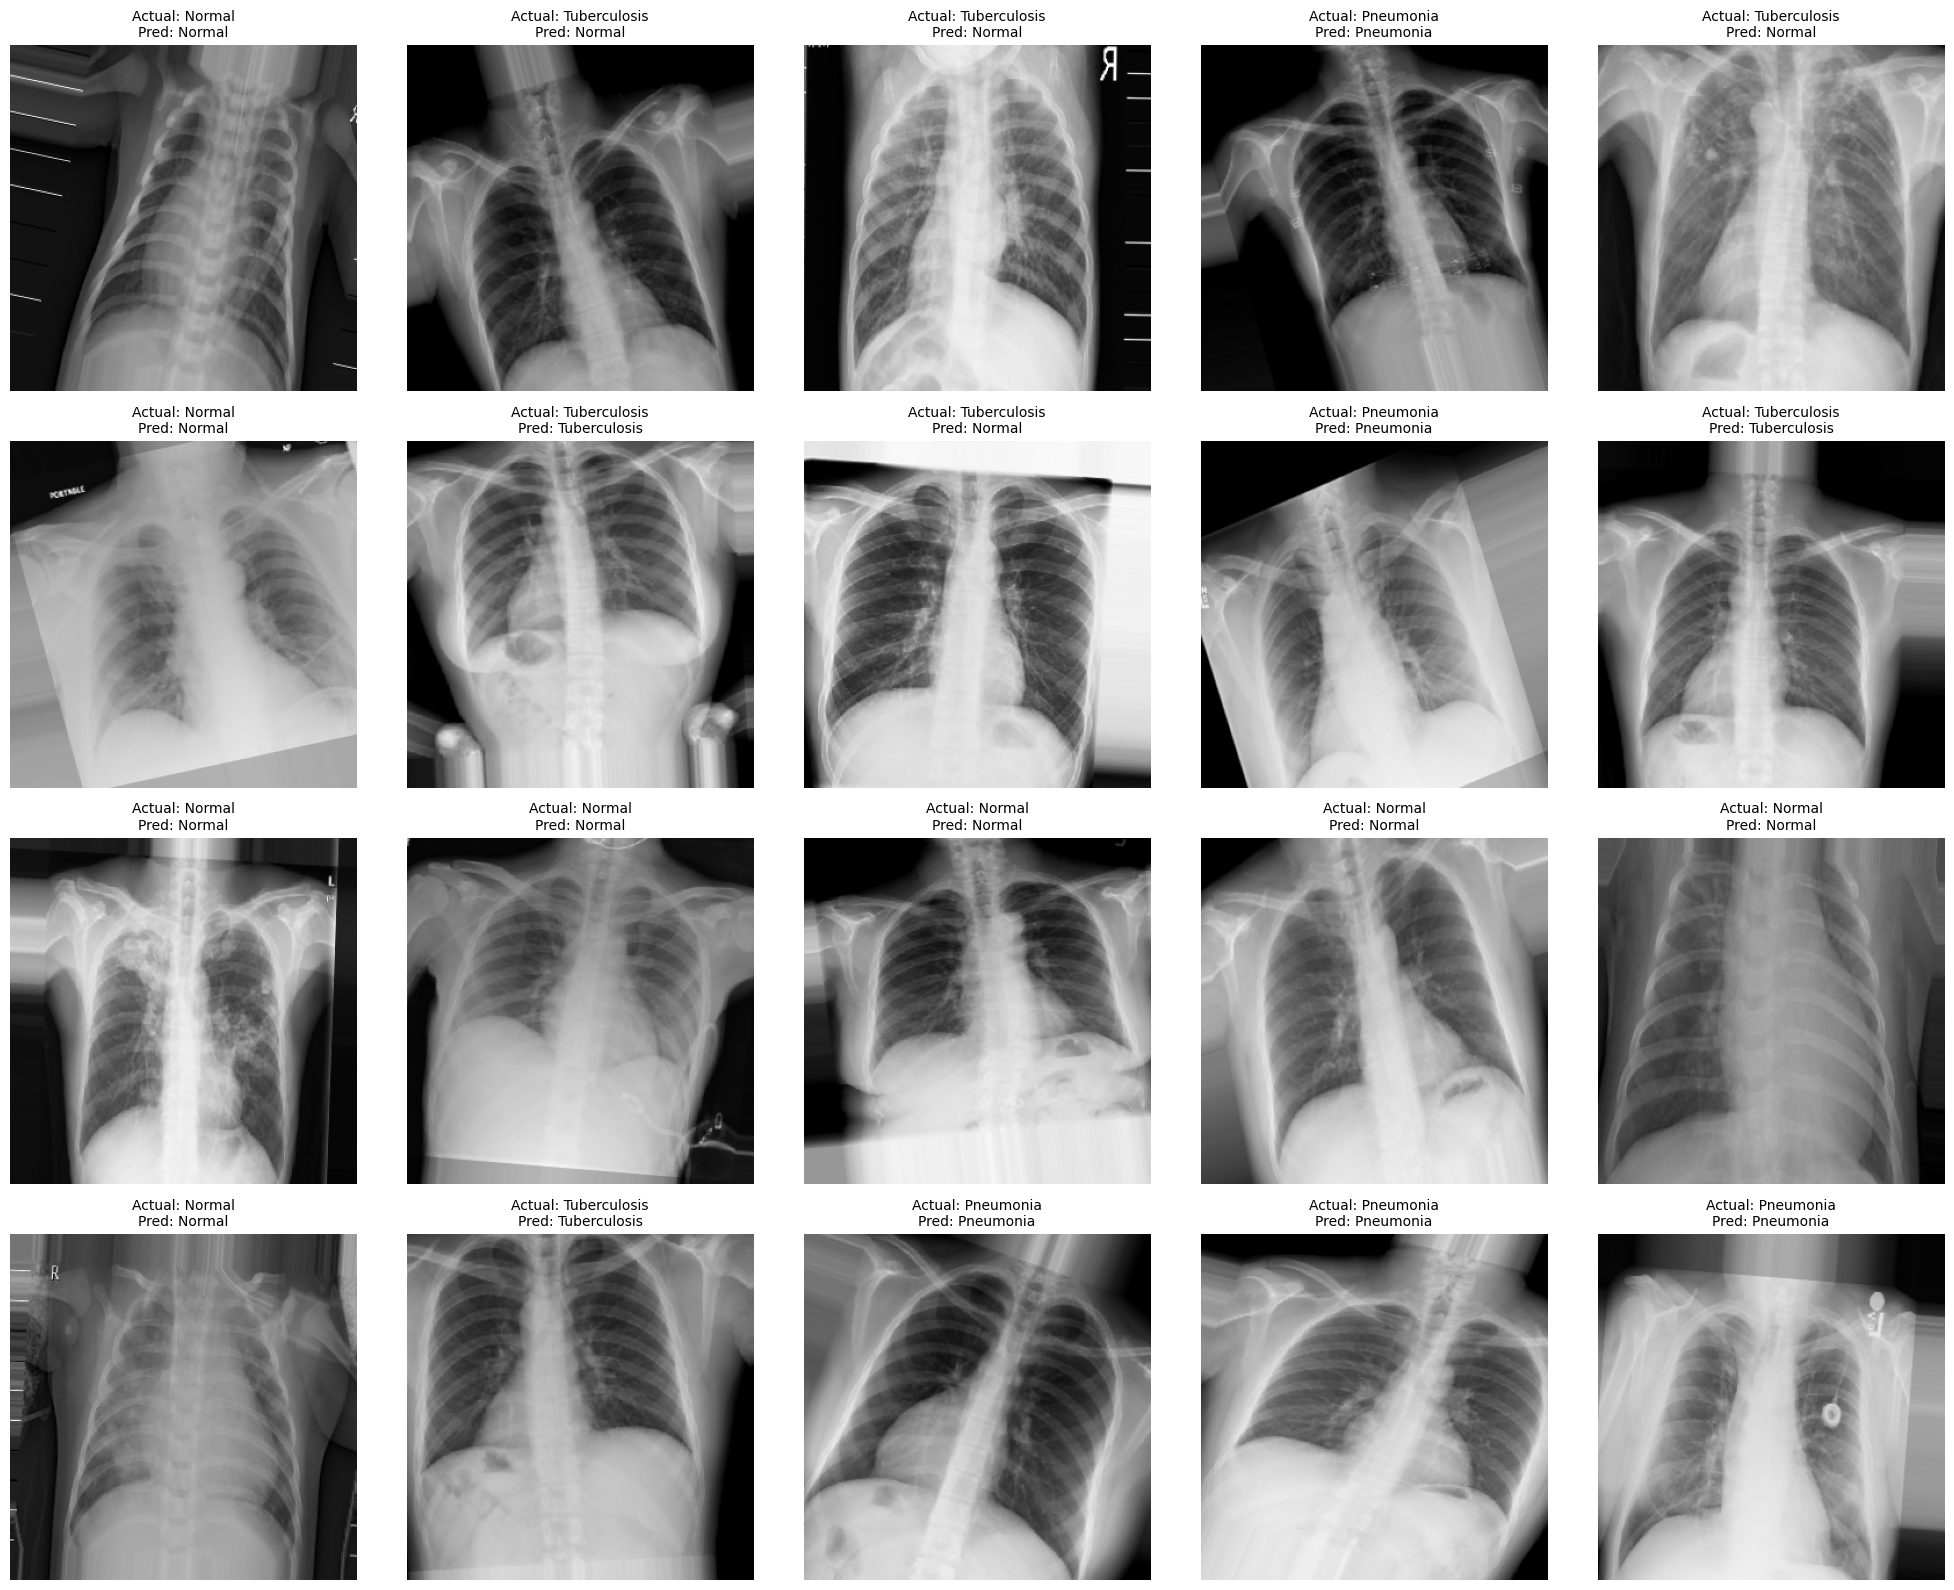

In [23]:
fig = plt.figure(figsize=(30,30))
n_show = min(20, len(images))


rows = 4
cols = math.ceil(n_show / rows)

fig = plt.figure(figsize=(4*cols, 4*rows))  # each image 4x4 inches

for i in range(n_show):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(images[i])
    actual_name = idx_to_class[true_idx[i]]
    pred_name   = idx_to_class[pred_idx[i]]
    ax.set_title(f"Actual: {actual_name}\nPred: {pred_name}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


# AS THE MODEL ACCURACY IS ~ 80% , WHICH CAUSED 4 OUT OF 20 IMAGE AS MISCLASSIFIED IMAGES